In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Introduction
We are interested in selecting the most appropriate ("best") variant caller for identifying SNPs and indels in microbial genomes. To do this in a principled manner, we constructed a pipeline to:
1. synthesize variants from a reference genome as our truth set for evaluating variant callers.
2. compare variant caller performance on different types of variants.


### Variant calling

In [228]:
def sum_filtered(df, filter_column, min_value, variantlog=None, logrow=2):
    '''
    df: from csv generated by testing pipeline, via checker.py
    filter_column: string of column name to filter by
    min_value: minimum threshold for values to retain when filtering by filter_column
    variantlog: variant output log generated by testing pipeline, via variants.py
    logrow: row to get total mutations from (0-start)
    '''
    sums = {}
    if filter_column == 'DP':
        filtered = df[(df[filter_column] >= min_value) | df[filter_column].isna() & (df['BAM_DP'] >= min_value)]
    else:
        filtered = df[df[filter_column] >= min_value]
    for tool in set(filtered['TOOL']):
        sums[tool] = [sum(filtered.loc[filtered['TOOL'] == tool, 'TRUE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_NEG'])]
    filtered_sums = pd.DataFrame(data=sums).T
    filtered_sums.reset_index(inplace=True)
    filtered_sums.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
    filtered_sums[filter_column] = min_value
    filtered_sums['recall'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_neg'])
    filtered_sums['precision'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_pos'])
    
    # Sanity check: When min_value = 0, introduced mutations == postfilter mutations
    if variantlog is not None:
        with open(variantlog, 'r') as log:
            varsettings = log.readlines()
        filtered_sums['total_mut_intro'] = int(varsettings[logrow].split(':')[-1].strip())
        filtered_sums['total_mut_postfilter'] = filtered_sums['true_pos'] + filtered_sums['false_neg']
    else:
        filtered_sums['total_mut_intro'] = np.nan
        filtered_sums['total_mut_postfilter'] = np.nan
    
    return filtered_sums

def combine_filtered(df, filter_column, filter_min, filter_max, filter_step, variantlog=None, logrow=2):
    filtered_dfs = []
    for threshold in range(filter_min, filter_max + filter_step, filter_step):
        summarydf = sum_filtered(df, filter_column, threshold, variantlog, logrow)
        filtered_dfs.append(summarydf)
    combined_summaries = pd.concat(filtered_dfs, ignore_index=True)
    return combined_summaries

In [344]:
# Called datasets
h37rv1000snp = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3SNP_alltools_normalized_dp0_checked.csv')
h37rv1000ins = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3INS_alltools_normalized_dp0_checked.csv')
h37rv1000del = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3DEL_alltools_normalized_dp0_checked.csv')

# Filter on BAM_DP
h37rv1000snp_summary = combine_filtered(h37rv1000snp, 'BAM_DP', 0, 70, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3SNP.log')
h37rv1000ins_summary = combine_filtered(h37rv1000ins, 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log')
h37rv1000dup_summary = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'DUP'], 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 5)
h37rv1000rdm_summary = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'RDM'], 'BAM_DP', 0, 60, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 6)
h37rv1000inv_summary = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'INV'], 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 7)
h37rv1000del_summary = combine_filtered(h37rv1000del, 'BAM_DP', 0, 60, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3DEL.log')

h37rv1000snp_summary['dataset'] = 'SNP'
h37rv1000ins_summary['dataset'] = 'INSERTION'
h37rv1000dup_summary['dataset'] = 'DUPLICATION'
h37rv1000rdm_summary['dataset'] = 'RANDOM SEQUENCE INSERTION'
h37rv1000inv_summary['dataset'] = 'INVERSION'
h37rv1000del_summary['dataset'] = 'DELETION'

In [346]:
combined_df = pd.concat([h37rv1000snp_summary, h37rv1000ins_summary, h37rv1000del_summary], ignore_index=True)
combined_df2 = pd.concat([h37rv1000snp_summary, h37rv1000dup_summary, h37rv1000rdm_summary, h37rv1000inv_summary,
                         h37rv1000del_summary], ignore_index=True)

#### Precision vs. Recall

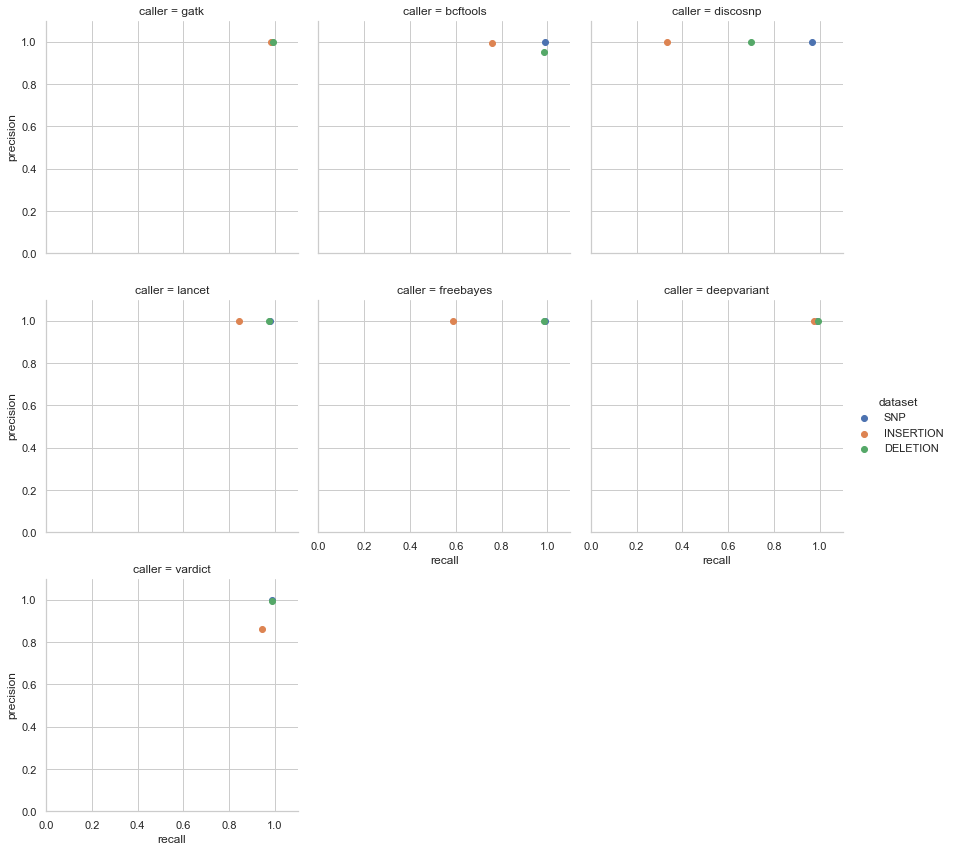

In [347]:
%matplotlib inline
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df[combined_df.BAM_DP == 0], hue='dataset', 
                   height=4, aspect=1, xlim=(0,1.1), ylim=(0,1.1),
                   col='caller', col_wrap=3)
fg.map(plt.scatter, 'recall', 'precision').add_legend()

#### Effect of read depths (BAM) on recall

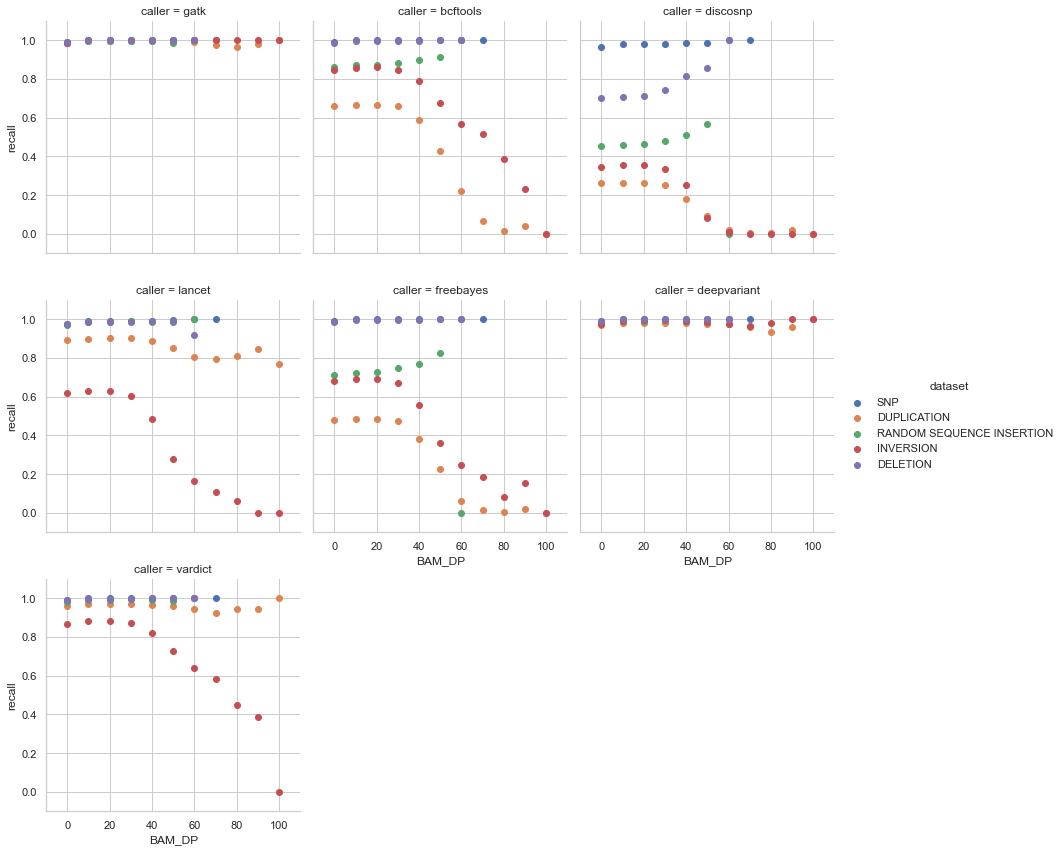

In [348]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df2, hue='dataset', height=4, aspect=1,
                   xlim=(-10,110), ylim=(-0.1,1.1),
                   col='caller', col_wrap=3)
fg.map(plt.scatter, 'BAM_DP', 'recall').add_legend()

#### Effect of read depths (BAM) on precision

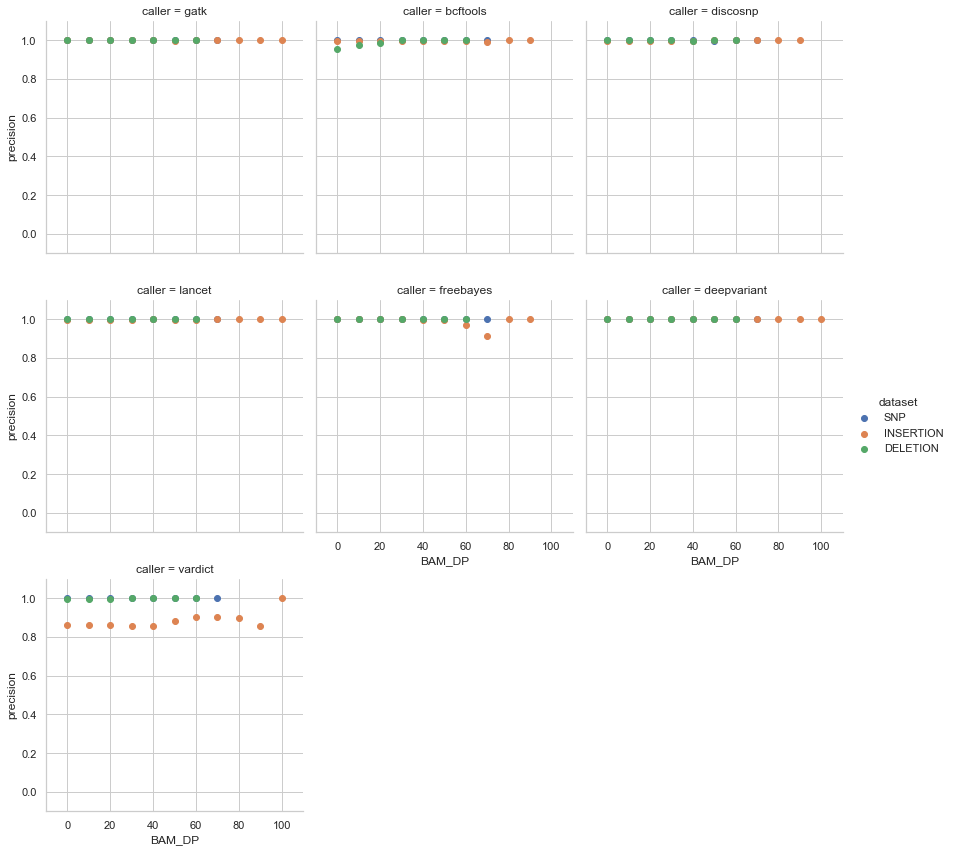

In [349]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df, hue='dataset', height=4, aspect=1,
                   xlim=(-10,110), ylim=(-0.1,1.1),
                   col='caller', col_wrap=3)
fg.map(plt.scatter, 'BAM_DP', 'precision').add_legend()

### In-house sequenced reads (H37Ra)

In [332]:
h37ra = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/sequenced/output/checked/sub1089-710-517_alltools_normalized_dp0_checked.csv')

In [333]:
h37ra_summary = combine_filtered(h37ra, 'BAM_DP', 0, 100, 10)

#### Precision vs. Recall (H37Ra)

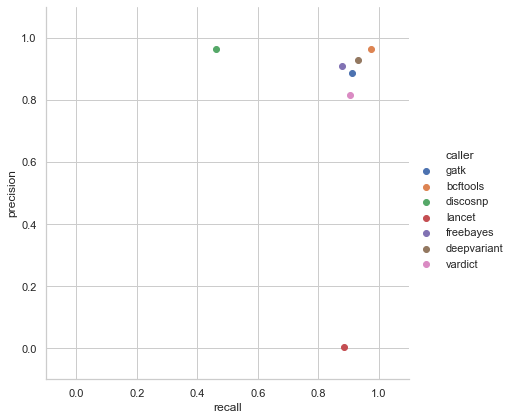

In [340]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=h37ra_summary[h37ra_summary.BAM_DP == 0], hue='caller', 
                   height=6, aspect=1, xlim=(-0.1,1.1), ylim=(-0.1,1.1))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

#### Recall, precision vs. read depth filtering (BAM_DP)

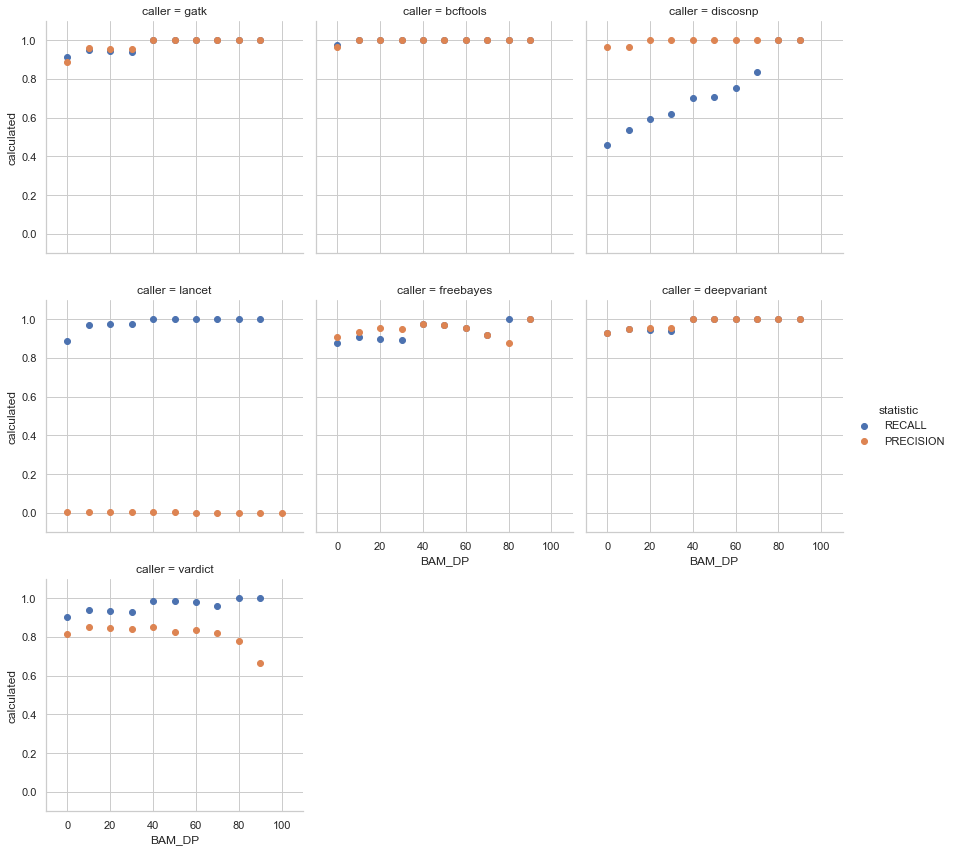

In [335]:
h37ra_recall = h37ra_summary.drop(['precision', 'total_mut_intro', 'total_mut_postfilter'], axis = 1)
h37ra_recall.rename(columns={'recall': 'calculated'}, inplace=True)
h37ra_recall['statistic'] = 'RECALL'
h37ra_precision = h37ra_summary.drop(['recall', 'total_mut_intro', 'total_mut_postfilter'], axis = 1)
h37ra_precision.rename(columns={'precision': 'calculated'}, inplace=True)
h37ra_precision['statistic'] = 'PRECISION'

h37ra_reshaped = pd.concat([h37ra_recall, h37ra_precision], ignore_index=True)

# Plot
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=h37ra_reshaped, height=4, aspect=1, xlim=(-10,110), ylim=(-0.1,1.1), 
                   col='caller', col_wrap=3, hue='statistic')
fg.map(plt.scatter, 'BAM_DP', 'calculated').add_legend()

### Validation of variant synthesis

We use `variants.py` to introduce SNPs and/or indels at a density of 1 every 1,000 bp into the *M. tuberculosis* H37Rv reference genome (NC_000962.3).

#### Datasets

- H37Rv10-3SNP: 4364 SNPs
- H37Rv10-3IND1: 4317 indels (1119 duplications + 524 random-sequence insertion + 558 inversions + 2116 deletions)
- H37Rv10-3INS: 4401 insertions only (2204 duplications + 1089 random-sequence insertion + 1108 inversions)
- H37Rv10-3DEL: 4285 deletions only

#### Reference and variant genome alignments

mauve?

In [74]:
# Reference genome
with open('/Users/yeemayseah/Documents/Repos/mtb_amr/data/GCF_000195955.2_ASM19595v2_genomic.fna') as fa:
    ref_fa = fa.readlines()
    ref = ''
    for lines in ref_fa[1:]:
        ref += lines.rstrip()

# Variant genome
with open('/Users/yeemayseah/Documents/Repos/mtb_amr/output/variants/H37Rv10-3SNP.fa', 'r') as inputfa:
    snp1k_fa = inputfa.readlines()[1]

# Mutation list
snp1klist = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/variants/H37Rv10-3SNP.txt', sep='\t')
snp1klist.head()

,#CHROM,POS,ID,REF,ALT,TYPE,INS_TYPE
0,NC_000962.3,844,.,A,G,SNP,NaN
1,NC_000962.3,2677,.,A,G,SNP,NaN
2,NC_000962.3,4316,.,C,G,SNP,NaN
3,NC_000962.3,5666,.,G,A,SNP,NaN
4,NC_000962.3,6403,.,T,C,SNP,NaN


In [71]:
print(ref[843], ref[2676], ref[4315], ref[5665], ref[6402])
print(snp1k_fa[843], snp1k_fa[2676], snp1k_fa[4315], snp1k_fa[5665], snp1k_fa[6402])

A A C G T
G G G A C


In [70]:
snp1klist.tail()

,#CHROM,POS,ID,REF,ALT,TYPE,INS_TYPE
4359,NC_000962.3,4405635,.,C,G,SNP,NaN
4360,NC_000962.3,4406429,.,A,C,SNP,NaN
4361,NC_000962.3,4408076,.,T,C,SNP,NaN
4362,NC_000962.3,4409506,.,G,T,SNP,NaN
4363,NC_000962.3,4410737,.,C,A,SNP,NaN


In [73]:
print(ref[4405634], ref[4406428], ref[4408075], ref[4409505], ref[4410736])
print(snp1k_fa[4405634], snp1k_fa[4406428], snp1k_fa[4408075], snp1k_fa[4409505], snp1k_fa[4410736])

C A T G C
G C C T A


##### Synthetic Reads

ART was used to simulate reads based on the reference and variant genomes, with the following parameters:

In [79]:
# Distribution of simulated read lengths per dataset

### Read Mapping and Depths
Reads with MAPQ < 10 are removed.

In [117]:
# Read depth across genomes
snp1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3SNP_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)
ind1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3IND1_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)
ins1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3INS_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)
del1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3DEL_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)

In [118]:
snp1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)
ind1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)
ins1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)
del1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)

<AxesSubplot:xlabel='pos'>

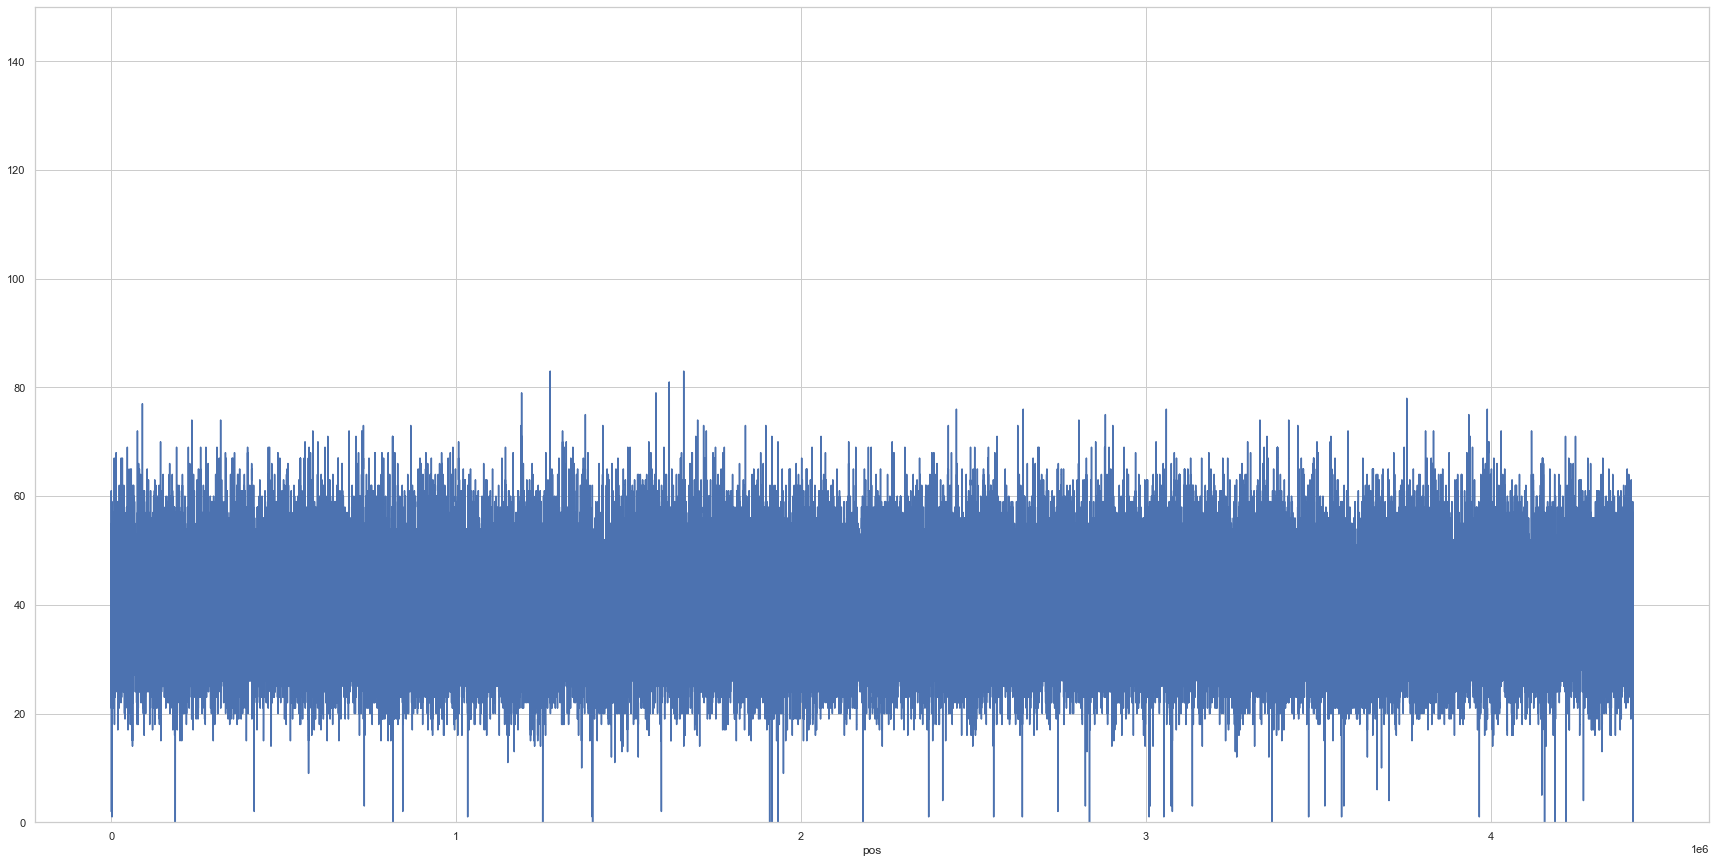

In [145]:
snp1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

<AxesSubplot:xlabel='pos'>

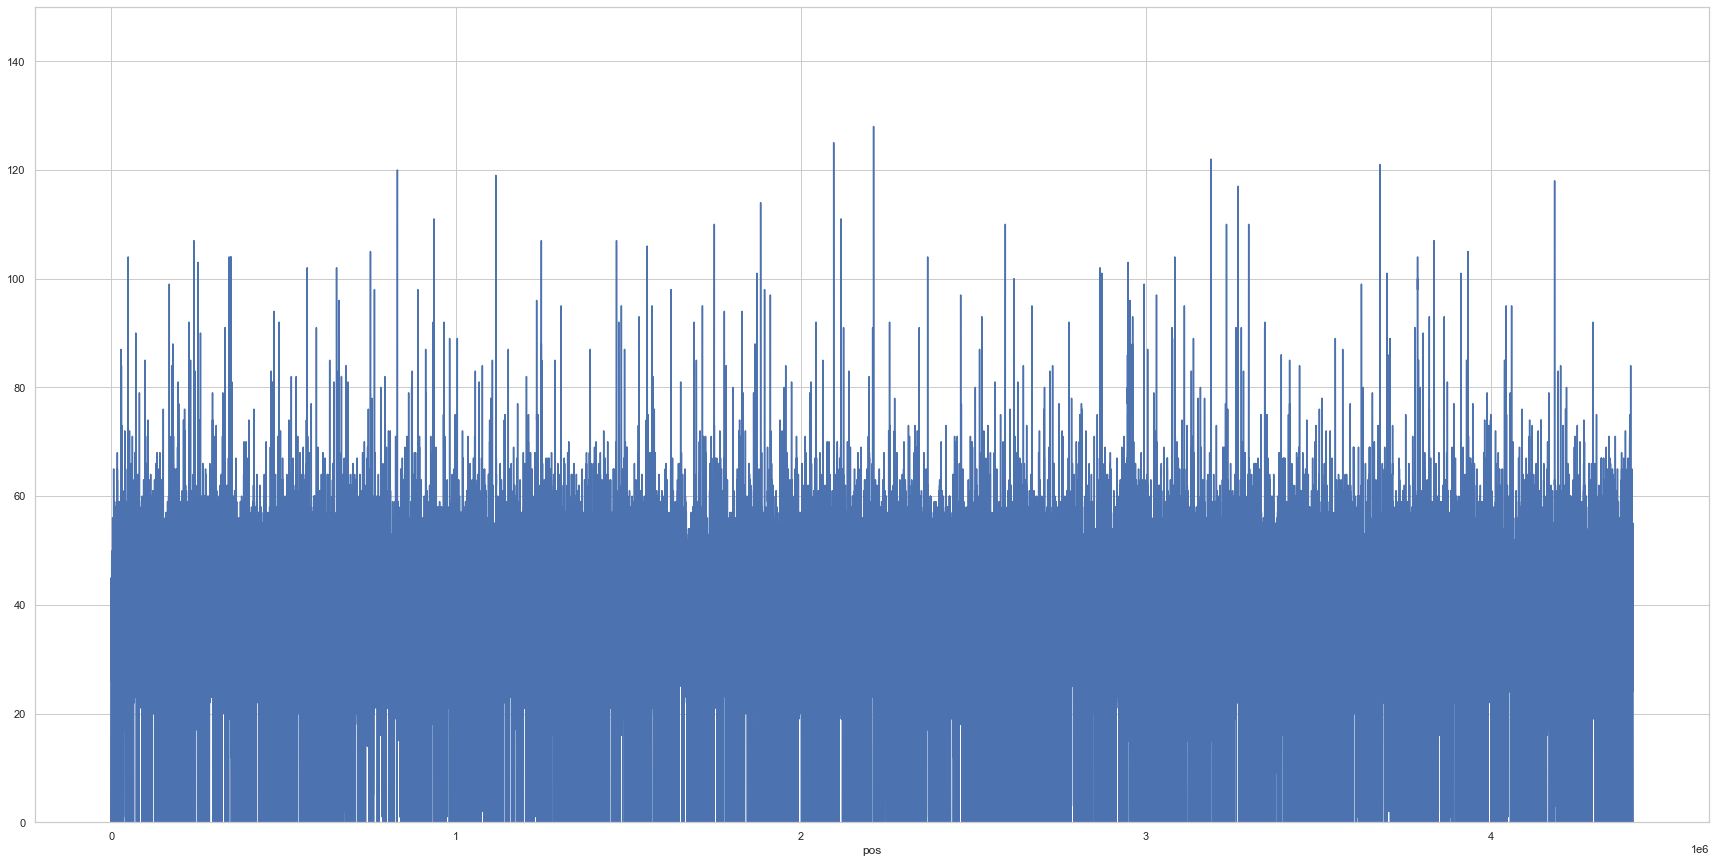

In [144]:
ind1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

<AxesSubplot:xlabel='pos'>

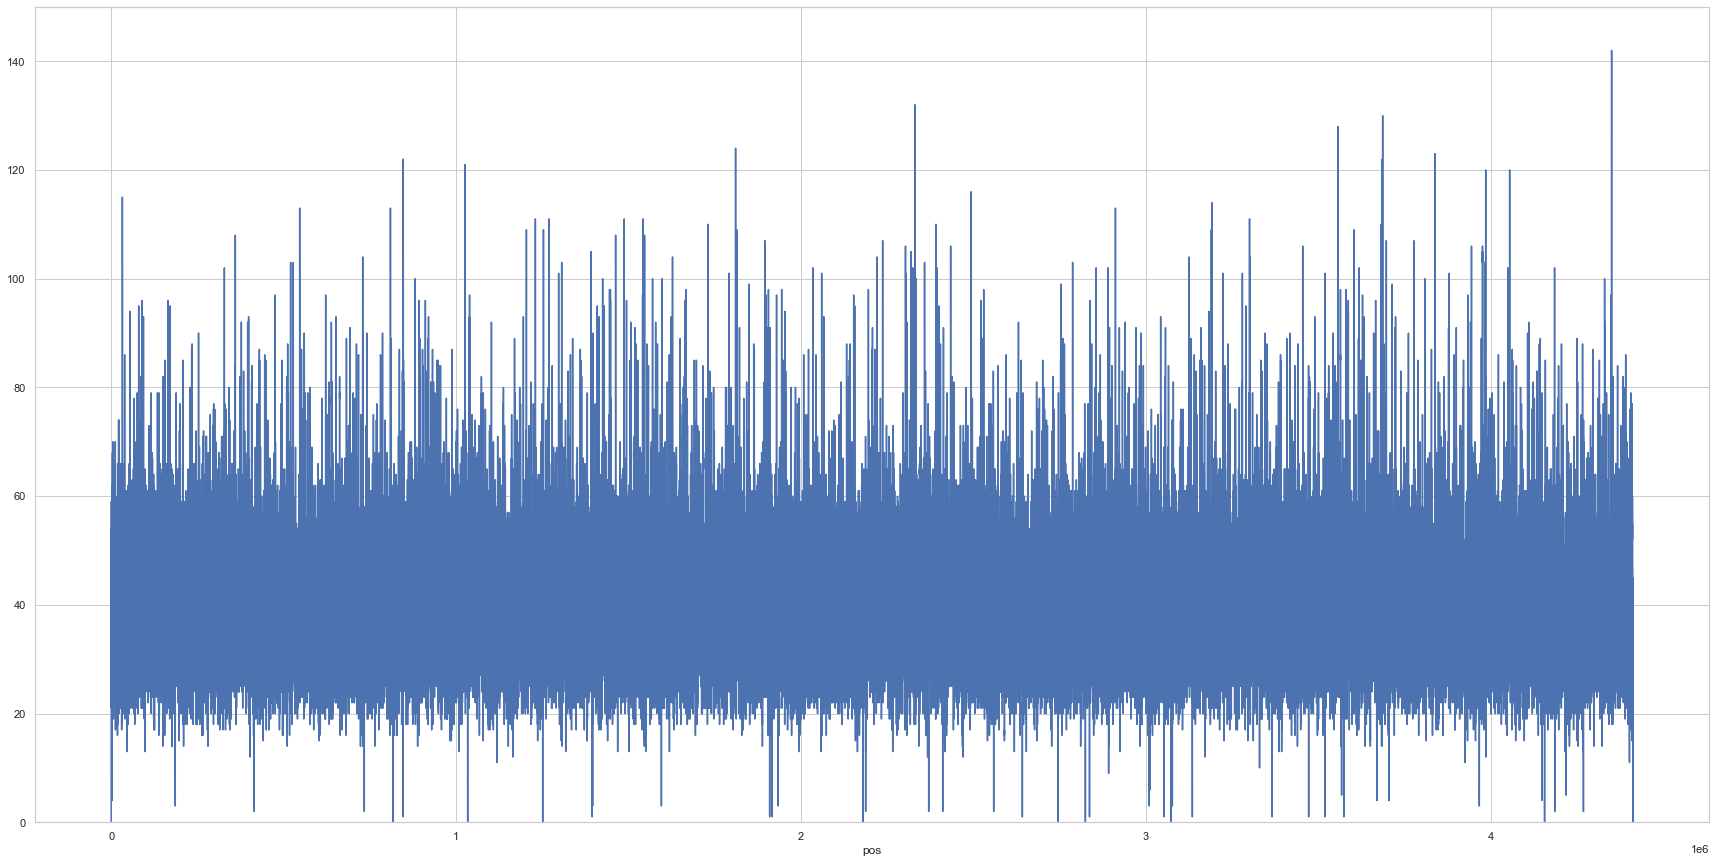

In [143]:
ins1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

<AxesSubplot:xlabel='pos'>

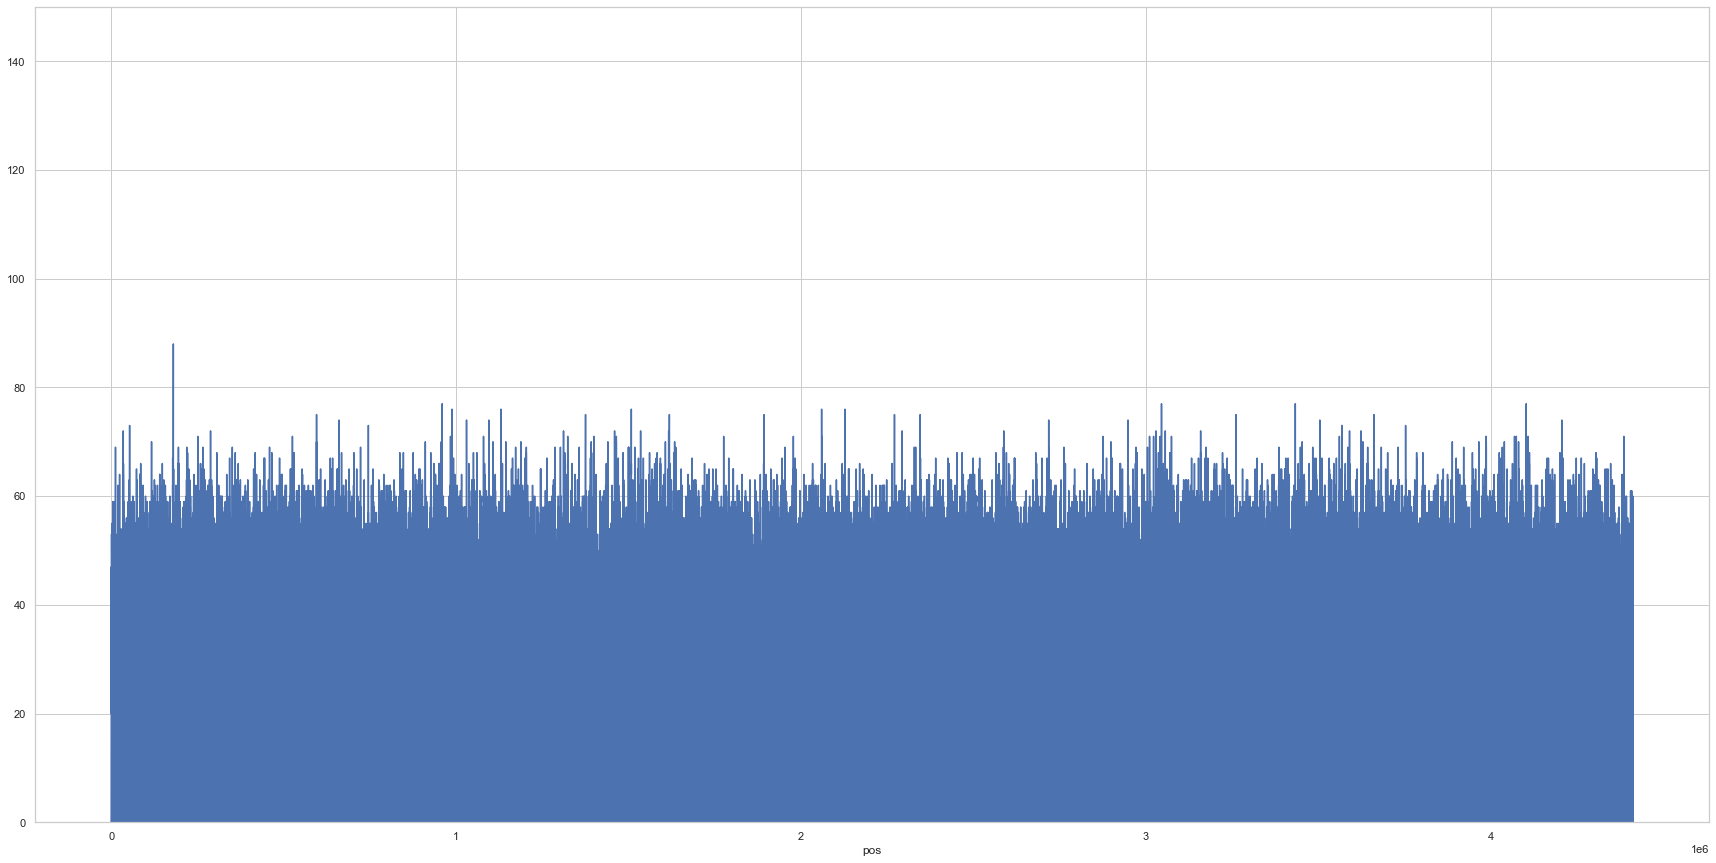

In [147]:
del1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

In [76]:
# Mapping quality across genomes